In [ ]:
!pip install matchms
!pip install rdkit
!pip install torch_geometric
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.1/235.1 kB 9.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 39.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 10.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910476 sha256=1ef4dc7eb6bc895259c51af2dee517aea5ca7d3fe880b5be775286e33cfbb433
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dc

In [ ]:
from matchms.importing import load_from_msp
import numpy as np
import os
import random
import pickle
import glob
import time
import re
from rdkit import Chem
from rdkit.Chem import Descriptors
import matchms
from matchms import Spectrum

import matplotlib.pyplot as plt
import warnings

from rdkit.Chem.rdmolops import GetAdjacencyMatrix

# Pytorch and Pytorch Geometric
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader

import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, GATConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn as nn
from torch_geometric.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/NIST_LIB/model_base_big.py model_base_big.py
!cp /content/drive/MyDrive/NIST_LIB/validation_metrics.py validation_metrics.py

In [ ]:
import model_base_big
import validation_metrics

In [ ]:
with open("/content/drive/MyDrive/NIST_SMALL/validation_subset_pow.pkl", 'rb') as handle:
    validation_dataset  = pickle.load(handle)

In [ ]:
REGEX = "*.pt"
PATH_MODELS = "/content/drive/MyDrive/NIST_SMALL/TRANSFORMER_CONV_MESSAGE_BIG_POW"
BATCH = 64
MAX_INTENSITY = 999.

In [ ]:
data_list_test = data_list_test[:5000]

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
matchms.set_matchms_logger_level("ERROR")

In [ ]:
EMBEDDING_SIZE = 2000
NODE_FEATURES = 50
EDGE_EMBEDDING = 10
MASS_SHIFT = 5 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def mask_prediction_by_mass(total_mass, raw_prediction, index_shift):
    # Zero out predictions to the right of the maximum possible mass.
    # input 
    # anchor_indices: shape (,batch_size) = ex [3,4,5]
    #     total_mass = Weights of whole molecule, not only fragment
    # data: shape (batch_size, embedding), embedding from GNN in our case
    # index_shift: int constant how far can heaviest fragment differ from weight of original molecule
    # 

    data = raw_prediction.type(torch.float64)
    
    total_mass = torch.round(total_mass).type(torch.int64)
    indices = torch.arange(data.shape[-1])[None, ...].to(device)

    right_of_total_mass = indices > (
            total_mass[..., None] +
            index_shift)
    return torch.where(right_of_total_mass, torch.zeros_like(data),
                        data)

In [ ]:

def scatter_by_anchor_indices(anchor_indices, data, index_shift):
    # reverse vector by anchor_indices and rest set to zero
    # input 
    # anchor_indices: shape (,batch_size) = ex [3,4,5]
    #     total_mass = Weights of whole molecule, not only fragment
    # data: shape (batch_size, embedding), embedding from GNN in our case
    # index_shift: int constant how far can heaviest fragment differ from weight of original molecule
    
    index_shift = index_shift
    anchor_indices = anchor_indices
    data = data.type(torch.float64)
    batch_size = data.shape[0]
    
    num_data_columns = data.shape[-1]
    indices = torch.arange(num_data_columns)[None, ...].to(device)
    shifted_indices = anchor_indices[..., None] - indices + index_shift
    valid_indices = shifted_indices >= 0

   

    batch_indices = torch.tile(
          torch.arange(batch_size)[..., None], [1, num_data_columns]).to(device)
    shifted_indices += batch_indices * num_data_columns

    shifted_indices = torch.reshape(shifted_indices, [-1])
    num_elements = data.shape[0] * data.shape[1]
    row_indices = torch.arange(num_elements).to(device)
    stacked_indices = torch.stack([row_indices, shifted_indices], axis=1)


    lower_batch_boundaries = torch.reshape(batch_indices * num_data_columns, [-1])
    upper_batch_boundaries = torch.reshape(((batch_indices + 1) * num_data_columns),
                                          [-1])

    valid_indices = torch.logical_and(shifted_indices >= lower_batch_boundaries,
                                     shifted_indices < upper_batch_boundaries)

    stacked_indices = stacked_indices[valid_indices]
    

    dense_shape = torch.tile(torch.tensor(num_elements)[..., None], [2]).type(torch.int32)

    scattering_matrix = torch.sparse.FloatTensor(stacked_indices.type(torch.int64).T,
                                                 torch.ones_like(stacked_indices[:, 0]).type(torch.float64),
                                                dense_shape.tolist())

    flattened_data = torch.reshape(data, [-1])[..., None]
    flattened_output = torch.sparse.mm(scattering_matrix, flattened_data)
    return torch.reshape(torch.transpose(flattened_output, 0, 1), [-1, num_data_columns])

In [ ]:
def reverse_prediction(total_mass, raw_prediction, index_shift):
    # reverse vector by anchor_indices and rest set to zero and make preproessing
    # input 
    # total_mass: shape (,batch_size) = ex [3,4,5]
    #     total_mass = Weights of whole molecule, not only fragment
    # raw_prediction: shape (batch_size, embedding), embedding from GNN in our case
    # index_shift: int constant how far can heaviest fragment differ from weight of original molecule
    #     total_mass = feature_dict[fmap_constants.MOLECULE_WEIGHT][..., 0]
    
    total_mass = torch.round(total_mass).type(torch.int32)
    return scatter_by_anchor_indices(
        total_mass, raw_prediction, index_shift)

In [ ]:
def dot_product(true, pred, mass_pow=3, intensity_pow=0.6):
    # shape for true and pred is one dimensional array
    # pred (number_of_predicted_bins)
    # defaul value for mass_pow and intensity_pow is set for Stein dot product
    assert true.ndim == pred.ndim and true.ndim == 1
    length = true.shape[-1]
    mass = np.arange(length).astype(np.float64)
        
    wl = mass ** mass_pow * pred**intensity_pow
    wu = mass ** mass_pow * true**intensity_pow
    
    pred_weighted_norm = np.sqrt(np.sum((wl**2)))
    true_weighted_norm = np.sqrt(np.sum((wu**2)))
    
    result = np.sum(wl*wu) / (pred_weighted_norm * true_weighted_norm)
    
    if np.isnan(result):
        result = 1
    
    return result

In [ ]:
def validate_similarities(true, pred, mass_pow, intensity_pow):
    # Helper function for validation
    similarities = np.array([])
    for true_instance, pred_instance in zip(true, pred):
        tmp = dot_product(true_instance, pred_instance, mass_pow=mass_pow, intensity_pow=intensity_pow)
        
        similarities = np.concatenate((similarities, tmp), axis=None)
    return similarities

In [ ]:
class SKIPblock(nn.Module):
    def __init__(self, in_features, hidden_features, USE_dropout=True, dropout_rate = 0.2):
        super().__init__()
        #only need to change shape of the residual if num_channels changes (i.e. in_c != out_c)
        #[bs,in_c,seq_length]->conv(1,in_c,out_c)->[bs,out_c,seq_length]
        
        self.hidden1= nn.utils.weight_norm(nn.Linear(in_features, hidden_features),name='weight',dim=0)
        if USE_dropout:
            self.dropout1 = nn.Dropout(dropout_rate)

        self.relu1 = nn.ReLU()

        self.hidden2 = nn.utils.weight_norm(nn.Linear(hidden_features, in_features),name='weight',dim=0)
        if USE_dropout:
            self.dropout2 = nn.Dropout(dropout_rate)
        self.relu2 = nn.ReLU()



    def forward(self, x):
        
        hidden = self.hidden1(x)
        hidden = self.dropout1(hidden)
        hidden = self.relu1(hidden)

        hidden = self.hidden2(hidden)
        hidden = hidden + x
        hidden = self.relu2(hidden)

        return hidden

In [ ]:
OUTPUT_SIZE = 1000
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, GATConv,GATv2Conv, TransformerConv

In [ ]:
class TRANSFORMER_CONV_MESSAGE_BIG(torch.nn.Module):
    def __init__(self, heads, dropout):
        # Init parent
        super(TRANSFORMER_CONV_MESSAGE_BIG, self).__init__()
        torch.manual_seed(42)
        EMBEDDING_SIZE_REDUCED = int(EMBEDDING_SIZE*0.1)

        # GCN layers
        self.initial_conv = TransformerConv(NODE_FEATURES, EMBEDDING_SIZE_REDUCED, heads=heads, beta=True, dropout=dropout, edge_dim=EDGE_EMBEDDING)
        self.conv1 = TransformerConv(EMBEDDING_SIZE_REDUCED*heads, EMBEDDING_SIZE_REDUCED, heads=heads, beta=True, dropout=dropout, edge_dim=EDGE_EMBEDDING)
        self.conv2 = TransformerConv(EMBEDDING_SIZE_REDUCED*heads, EMBEDDING_SIZE_REDUCED, heads=heads, beta=True, dropout=dropout, edge_dim=EDGE_EMBEDDING)
        self.conv3 = TransformerConv(EMBEDDING_SIZE_REDUCED*heads, EMBEDDING_SIZE_REDUCED, heads=heads, beta=True, dropout=dropout, edge_dim=EDGE_EMBEDDING)
        self.conv4 = TransformerConv(EMBEDDING_SIZE_REDUCED*heads, EMBEDDING_SIZE_REDUCED, concat=False, heads=heads, beta=True, dropout=dropout, edge_dim=EDGE_EMBEDDING)
        
        self.bottleneck = Linear(EMBEDDING_SIZE_REDUCED, EMBEDDING_SIZE)

        self.skip1 = SKIPblock(EMBEDDING_SIZE, EMBEDDING_SIZE)
        self.skip2 = SKIPblock(EMBEDDING_SIZE, EMBEDDING_SIZE)
        self.skip3 = SKIPblock(EMBEDDING_SIZE, EMBEDDING_SIZE)
        self.skip4 = SKIPblock(EMBEDDING_SIZE, EMBEDDING_SIZE)
        self.skip5 = SKIPblock(EMBEDDING_SIZE, EMBEDDING_SIZE)
        self.skip6 = SKIPblock(EMBEDDING_SIZE, EMBEDDING_SIZE)
        self.skip7 = SKIPblock(EMBEDDING_SIZE, EMBEDDING_SIZE)
        self.relu_out_resnet = nn.ReLU()

        self.forward_prediction = Linear(EMBEDDING_SIZE, OUTPUT_SIZE)
        self.backward_prediction = Linear(EMBEDDING_SIZE, OUTPUT_SIZE)
        self.gate = Linear(EMBEDDING_SIZE, OUTPUT_SIZE)

        self.relu_out = nn.ReLU()

    def forward(self, x, edge_index, edge_weight, total_mass, batch_index):
        
        hidden = self.initial_conv(x, edge_index, edge_weight)
        hidden = F.relu(hidden)
     
        # Other Conv layers
        hidden = self.conv1(hidden, edge_index, edge_weight)
        hidden = F.relu(hidden)
        hidden = self.conv2(hidden, edge_index, edge_weight)
        hidden = F.relu(hidden)
        hidden = self.conv3(hidden, edge_index, edge_weight)
        hidden = F.relu(hidden)
        hidden = self.conv4(hidden, edge_index, edge_weight)
        
      
        hidden = gap(hidden, batch_index)
        hidden = self.bottleneck(hidden)

        hidden = self.skip1(hidden)
        hidden = self.skip2(hidden)
        hidden = self.skip3(hidden)
        hidden = self.skip4(hidden)
        hidden = self.skip5(hidden)
        hidden = self.skip6(hidden)
        hidden = self.skip7(hidden)
        
        hidden = self.relu_out_resnet(hidden)

        # Bidirectional layer
        # Forward prediction
        forward_prediction_hidden = self.forward_prediction(hidden)
        forward_prediction_hidden = mask_prediction_by_mass(total_mass, forward_prediction_hidden, MASS_SHIFT)
        
        # # Backward prediction
        backward_prediction_hidden = self.backward_prediction(hidden)
        backward_prediction_hidden = reverse_prediction(total_mass, backward_prediction_hidden, MASS_SHIFT)
        
        # # Gate
        gate_hidden = self.gate(hidden)
        gate_hidden = F.sigmoid(gate_hidden)

        # # Apply a final (linear) classifier.
        out = gate_hidden * forward_prediction_hidden + (1. - gate_hidden) * backward_prediction_hidden
        out = self.relu_out(out)
        
        out = out.type(torch.float64)
        return out

In [ ]:
validation_loader_unshuffled = DataLoader(validation_dataset, 
                         batch_size=BATCH, shuffle=False)

heads = 4
dropout = 0.1
MODEL_CLASS = TRANSFORMER_CONV_MESSAGE_BIG(heads, dropout)
models_path = validation_metrics.load_each_model(PATH_MODELS, REGEX)

validation_metrics.load_models_and_predict(models_path, PATH_MODELS, MODEL_CLASS, validation_loader_unshuffled)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
REGEX_VALIDATION = r'^validation\d+\.pkl$'
validation_paths = validation_metrics.find_validation_files(PATH_MODELS, REGEX_VALIDATION)
statistics_validation = validation_metrics.compute_statistics_for_validation(validation_paths)

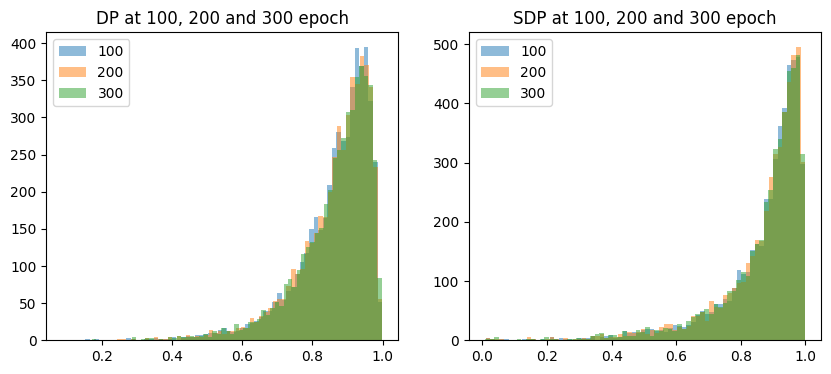

In [ ]:
validation_metrics.histograms_convolved(PATH_MODELS, statistics_validation)

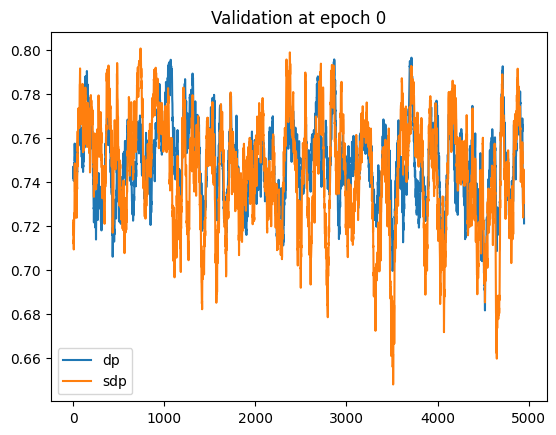

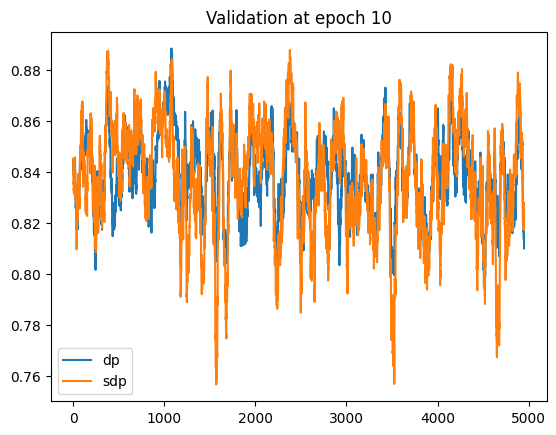

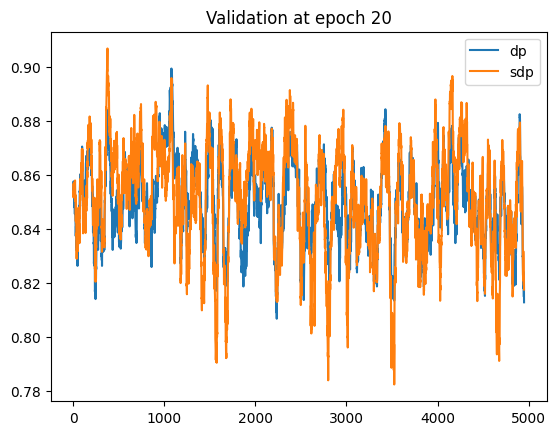

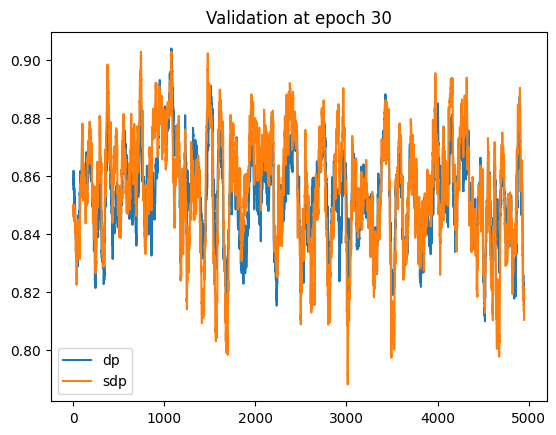

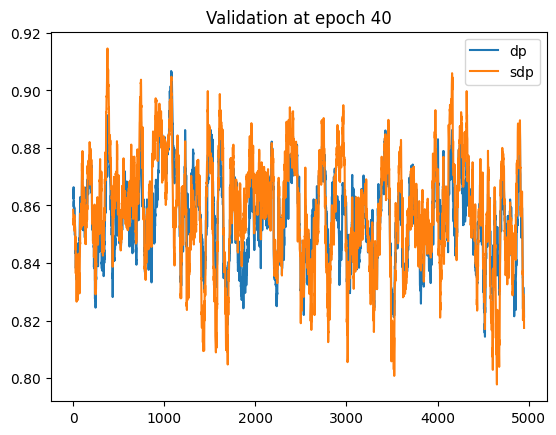

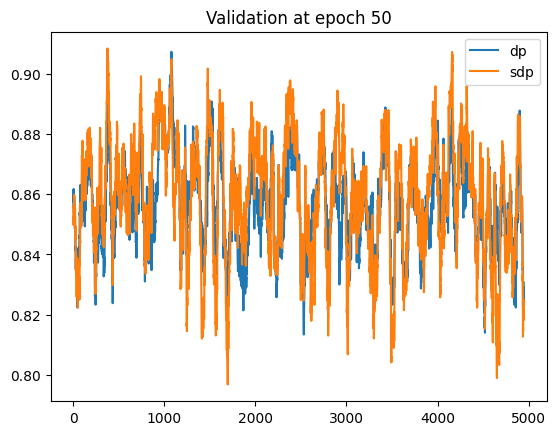

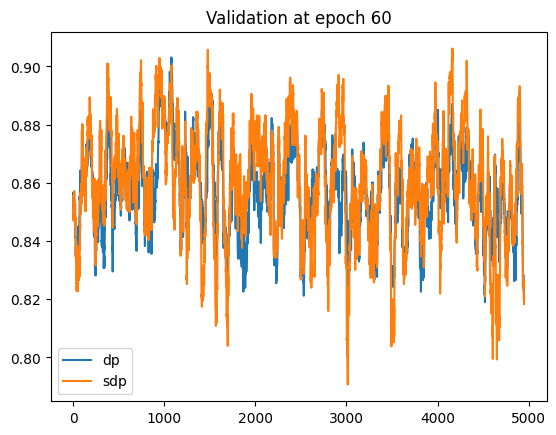

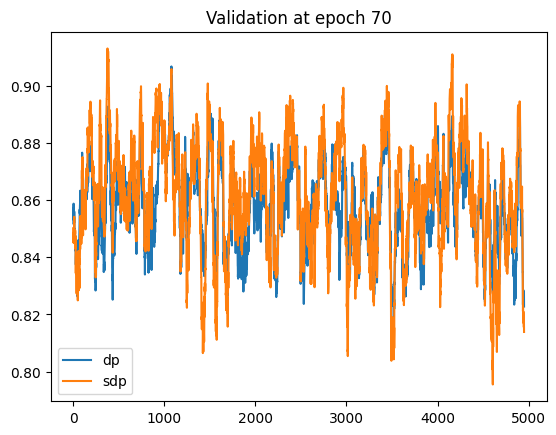

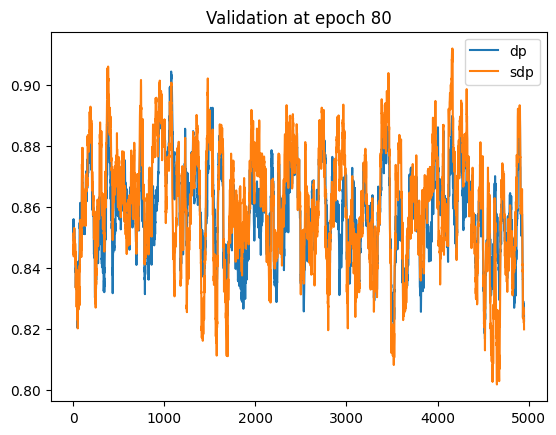

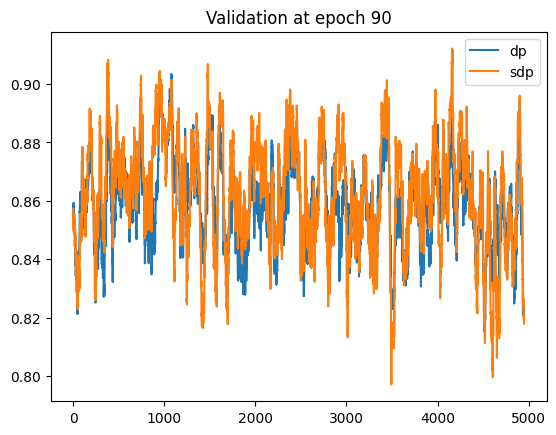

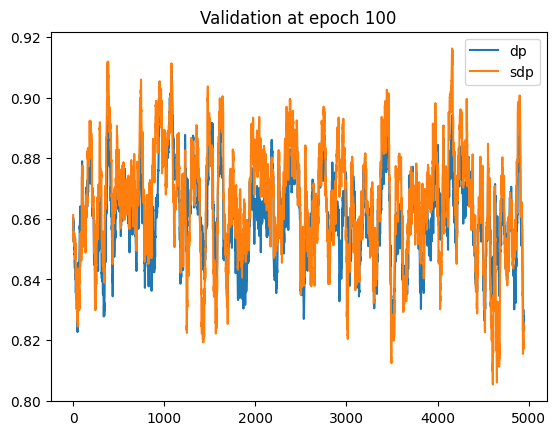

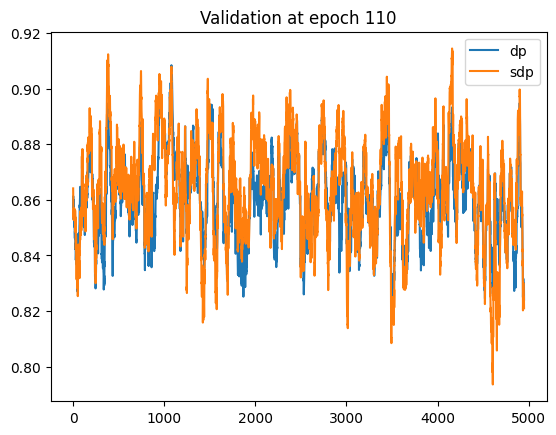

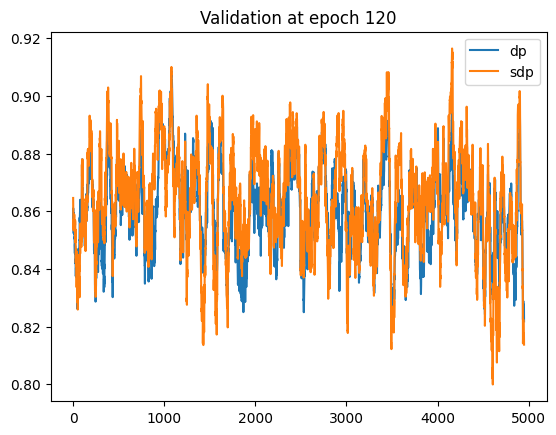

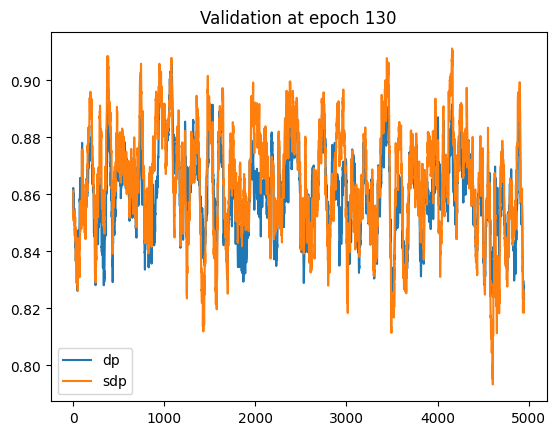

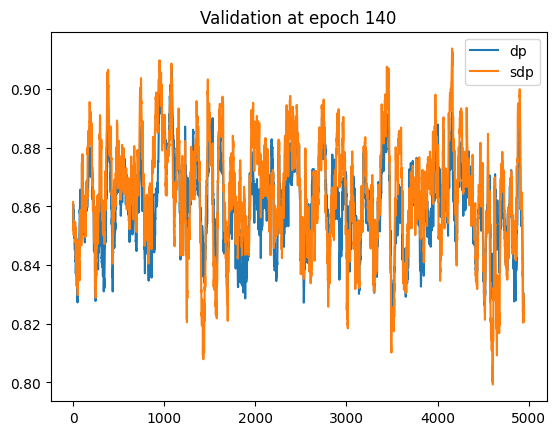

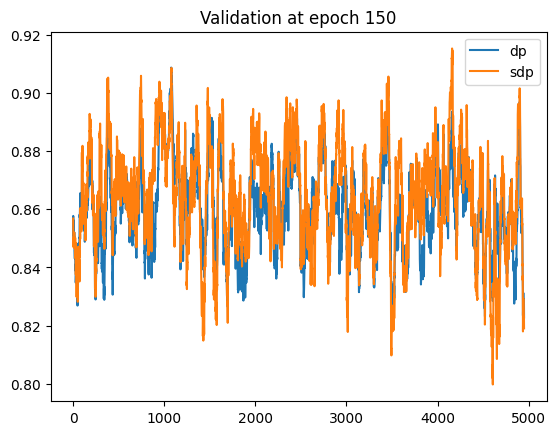

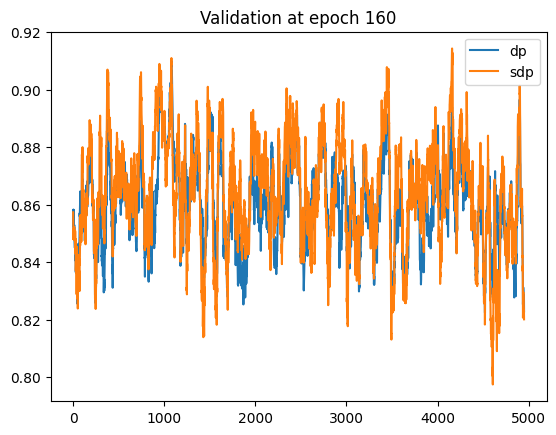

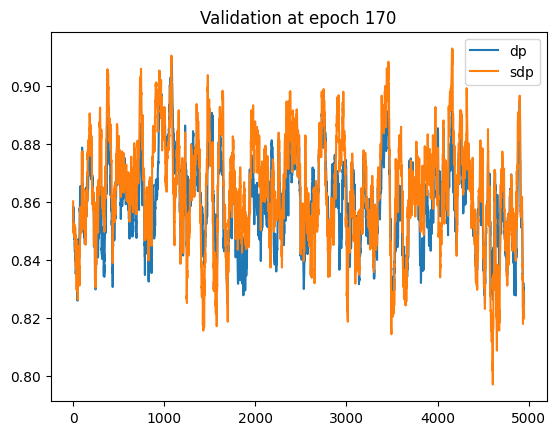

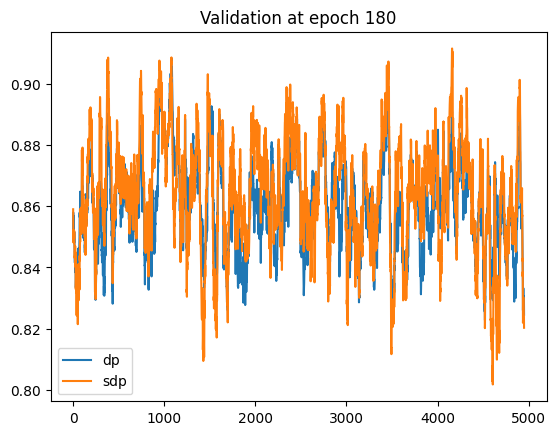

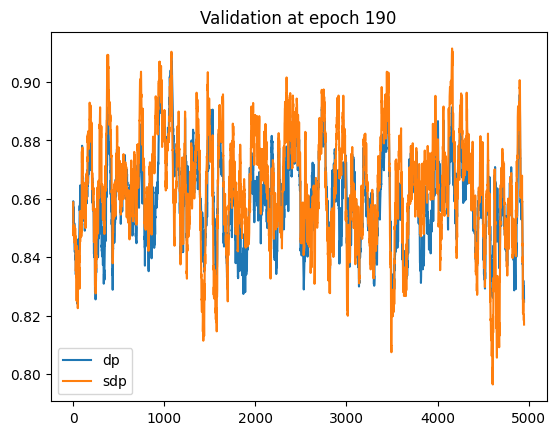

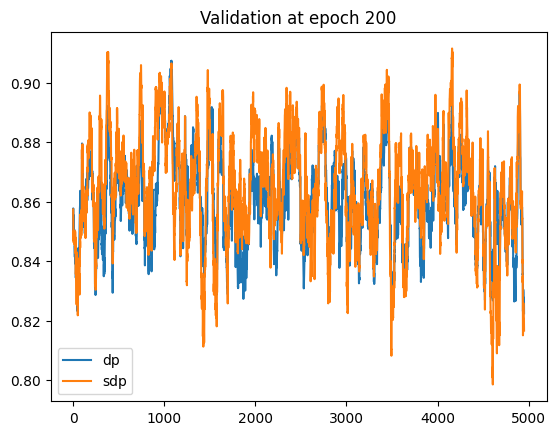

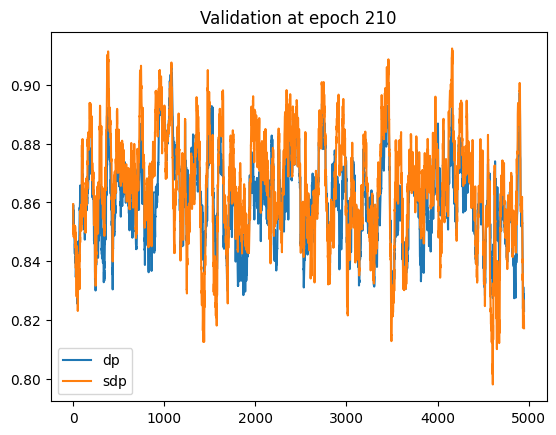

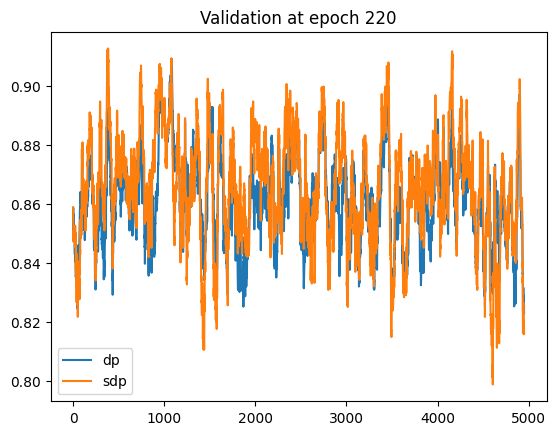

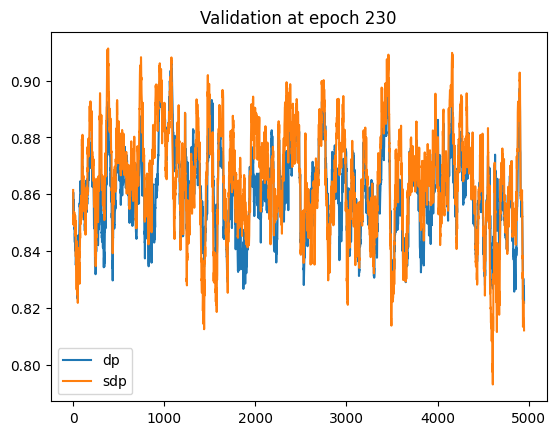

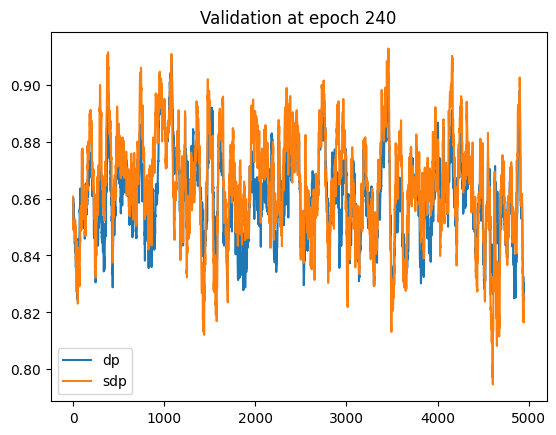

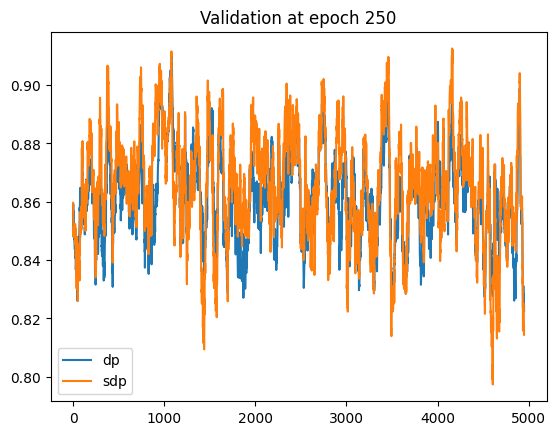

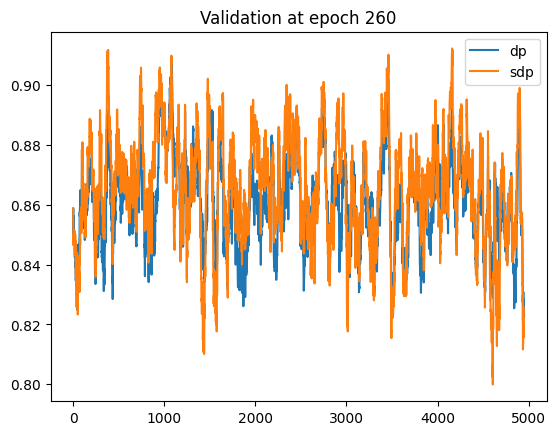

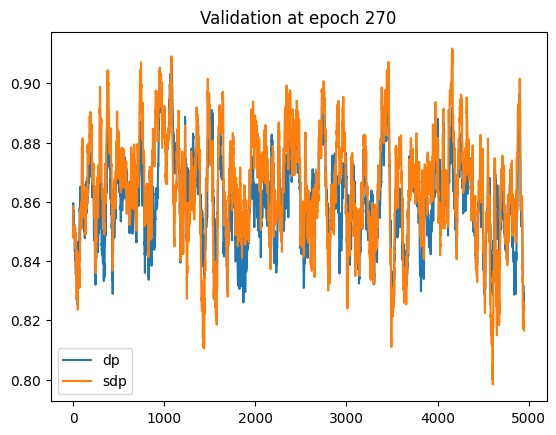

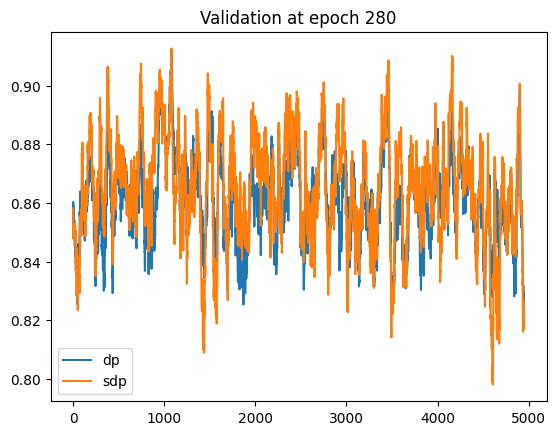

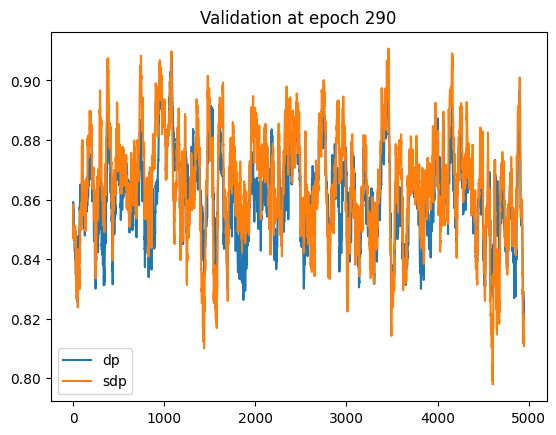

In [ ]:
validation_metrics.plot_convolve_mean(statistics_validation)

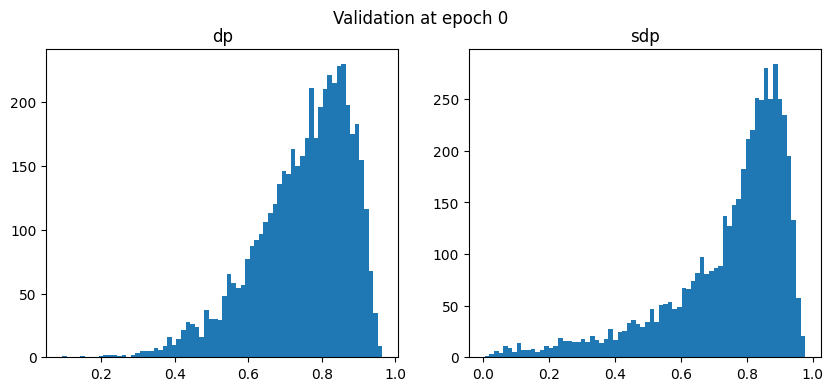

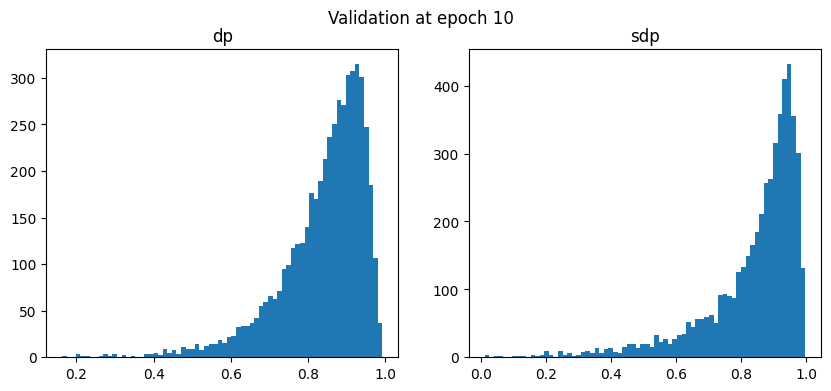

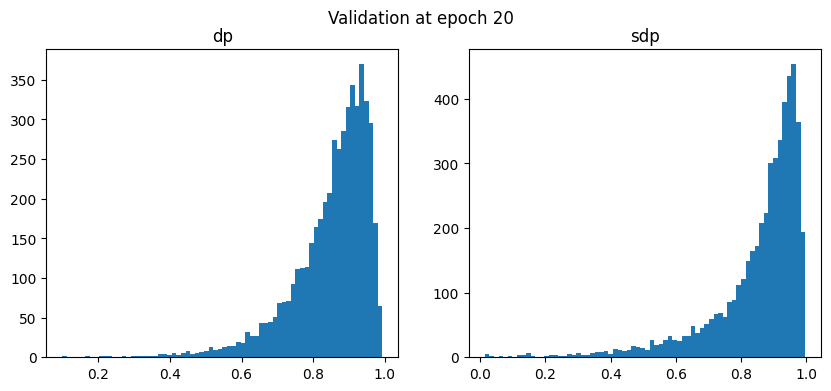

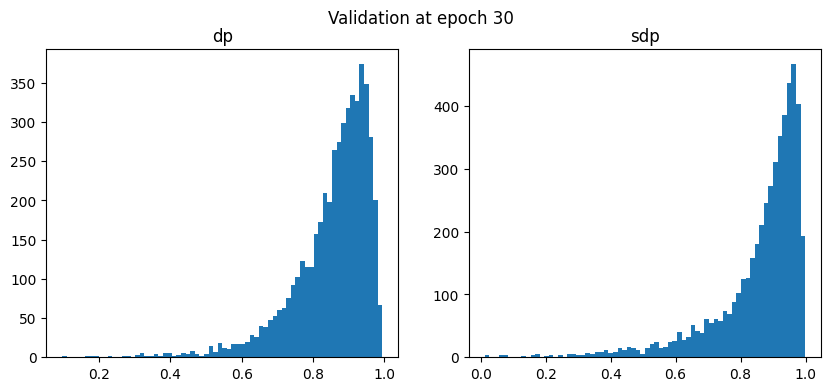

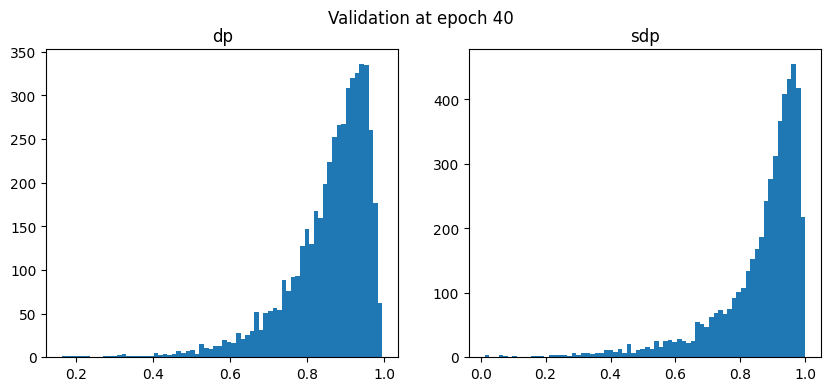

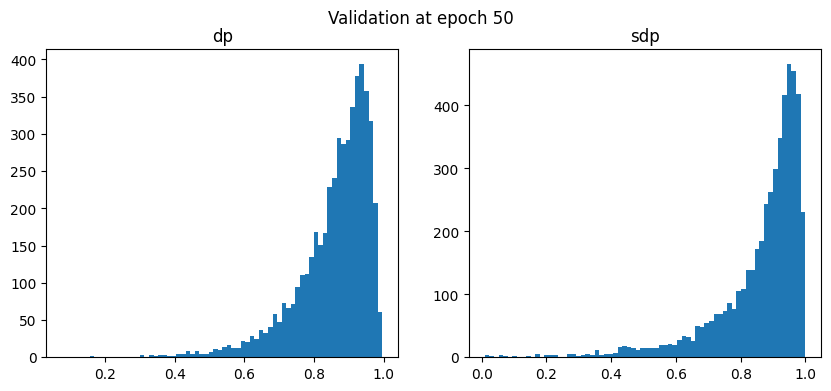

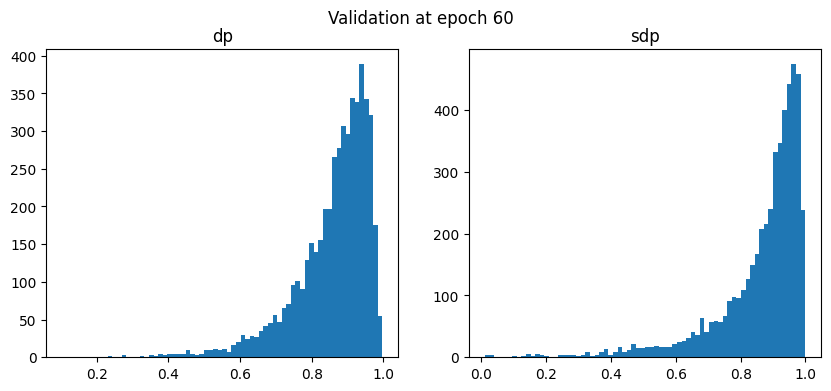

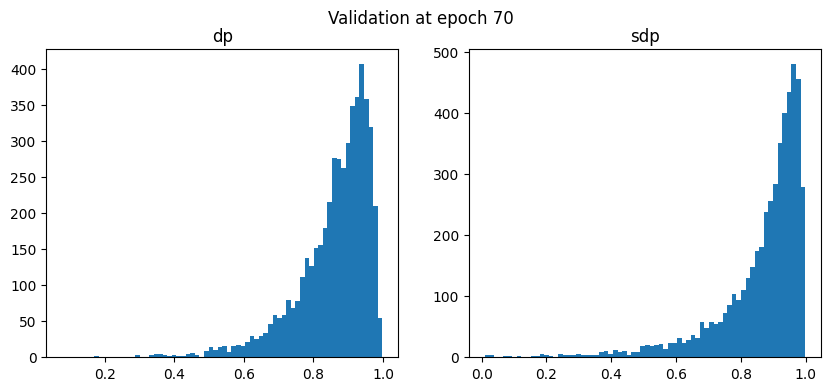

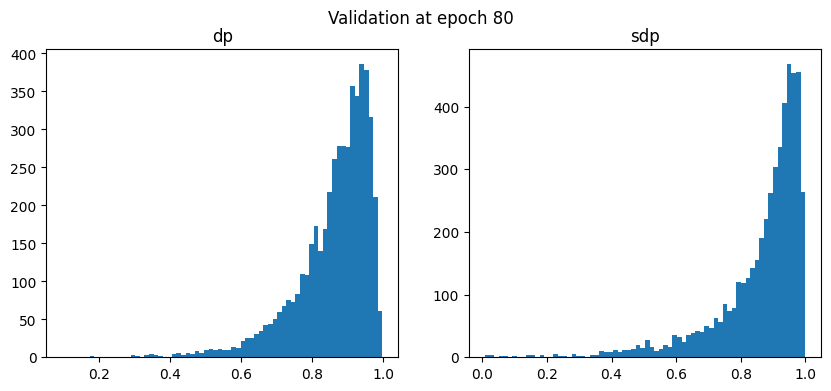

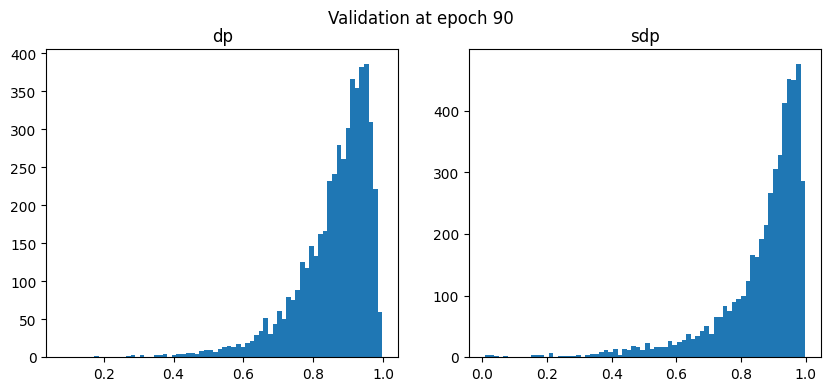

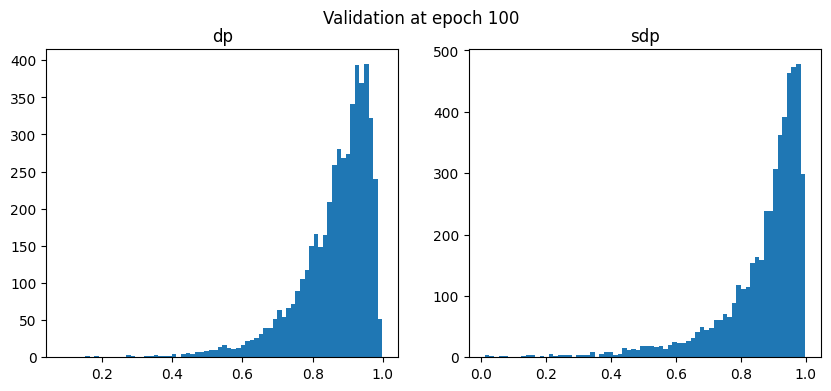

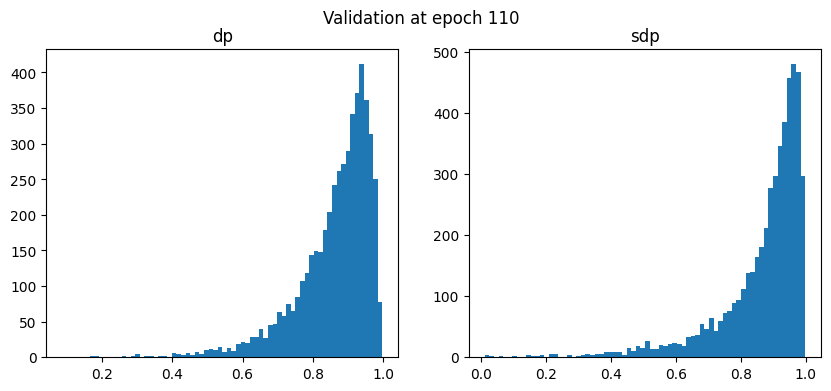

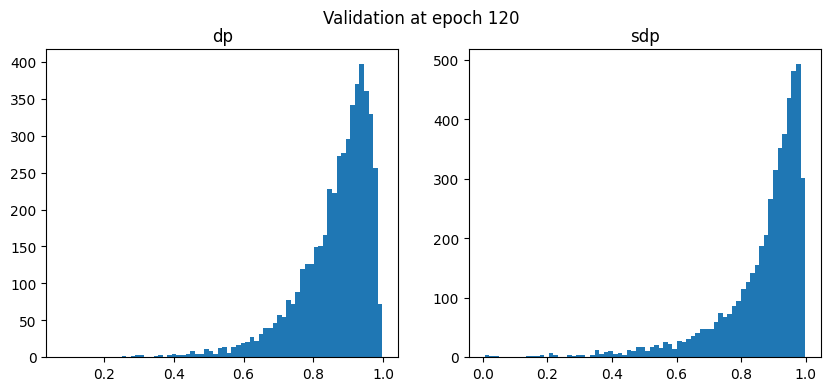

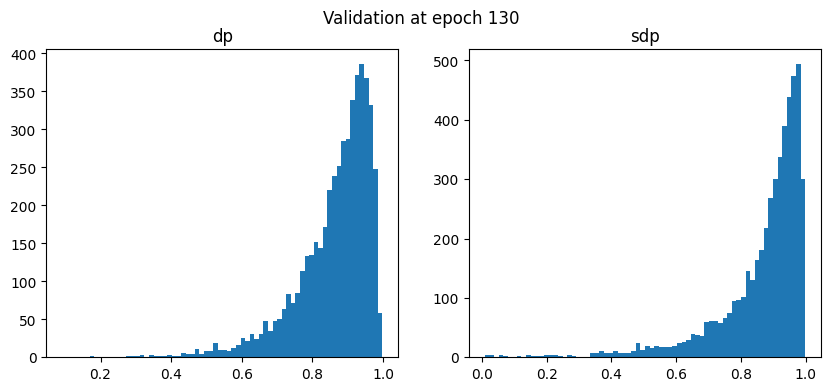

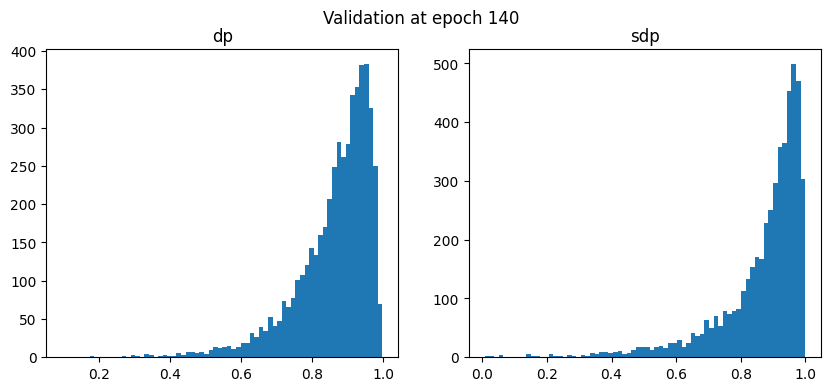

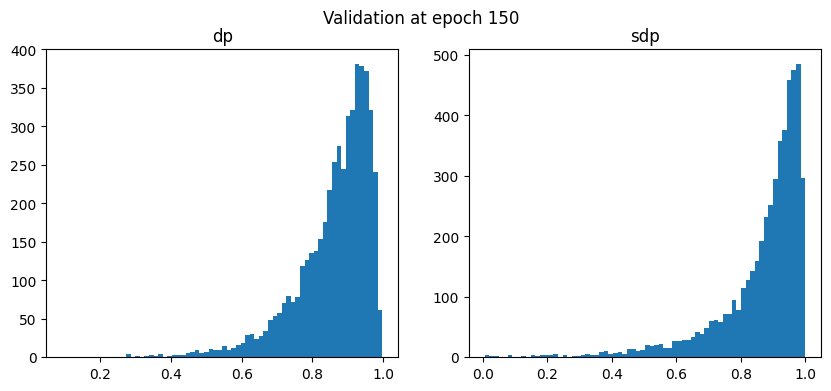

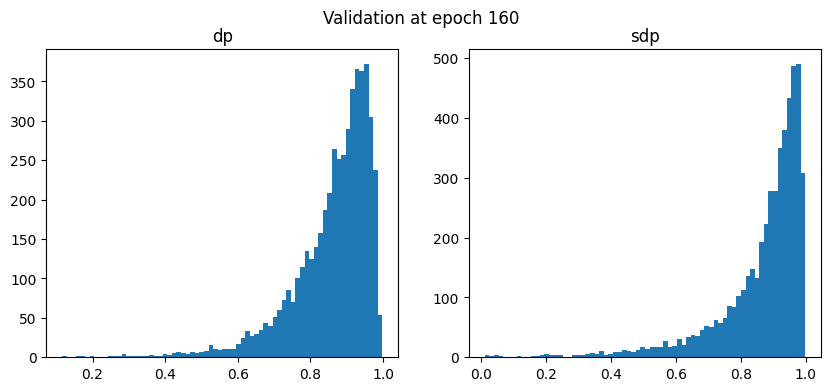

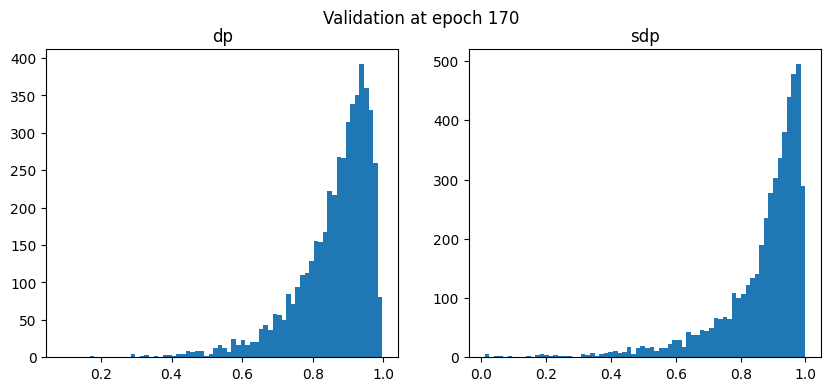

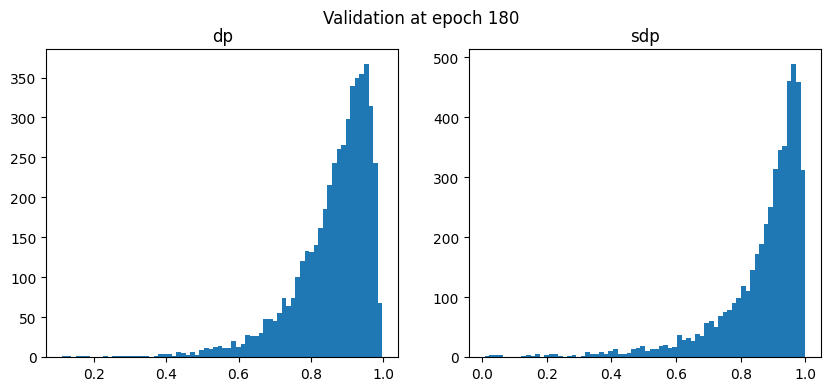

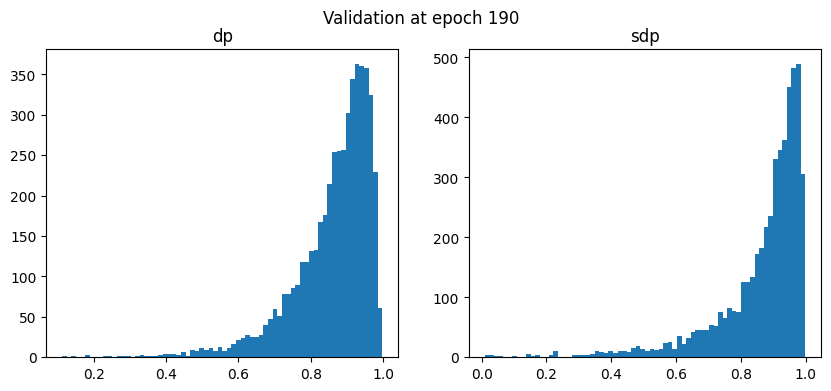

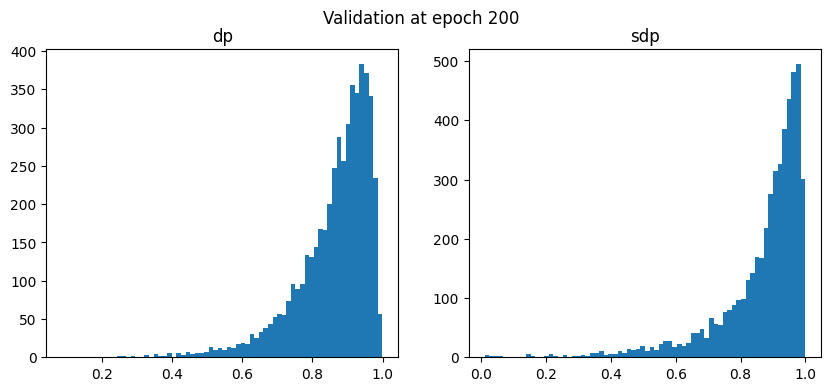

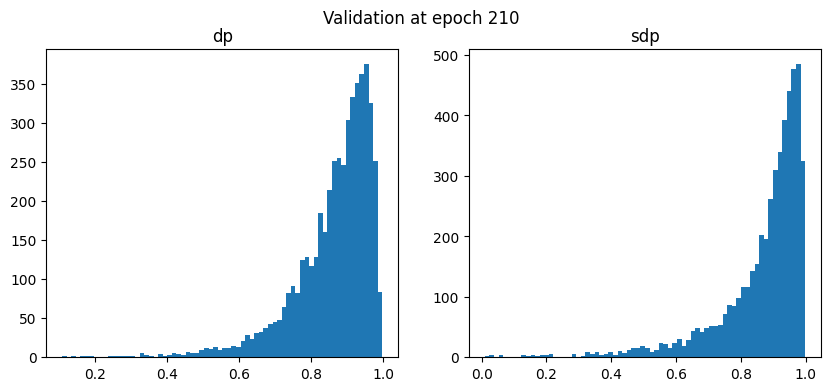

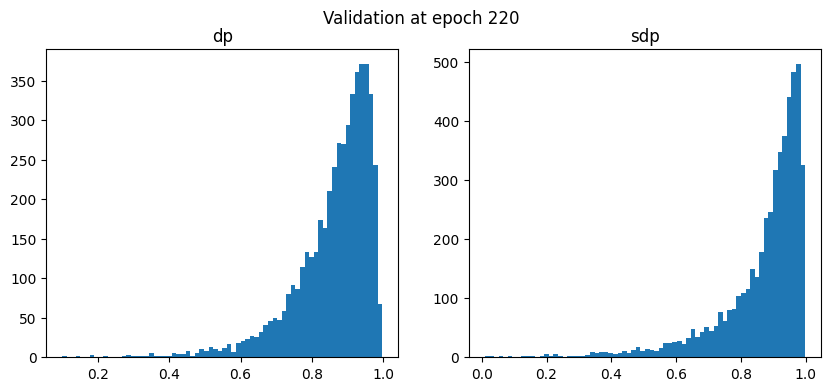

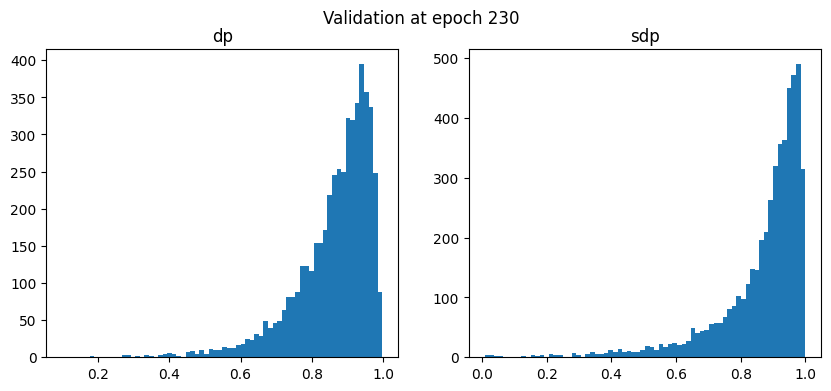

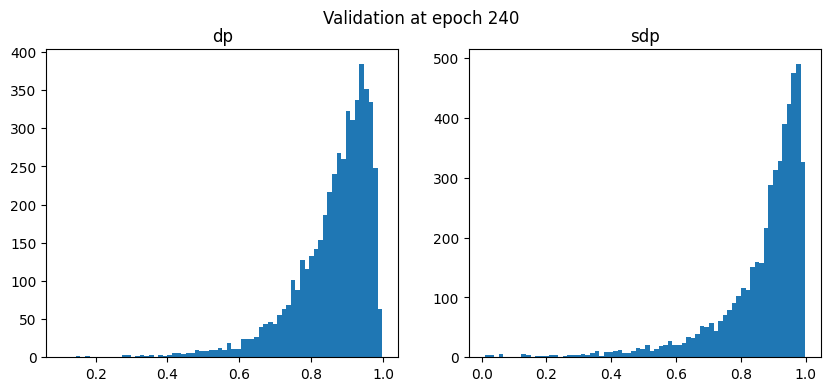

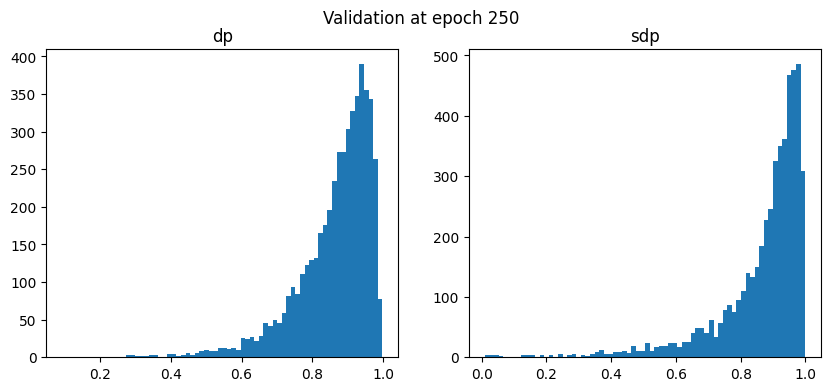

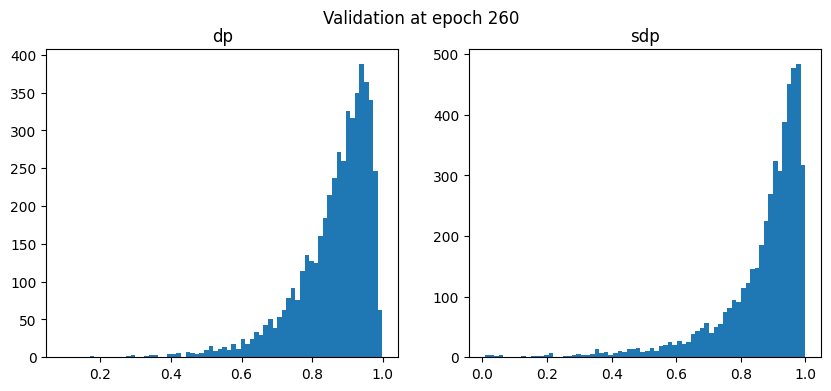

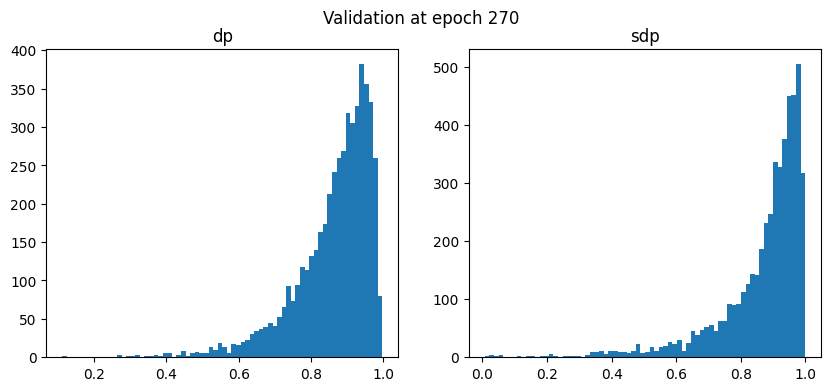

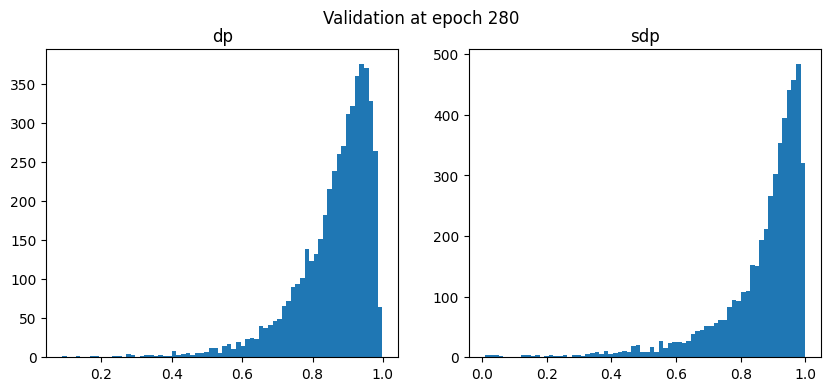

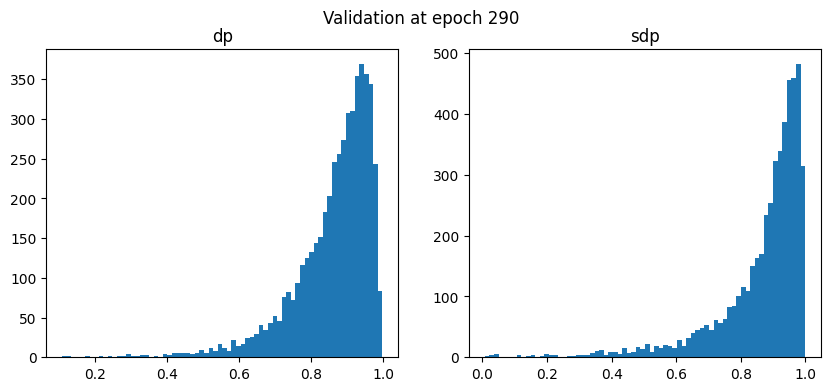

In [ ]:
validation_metrics.plot_histograms(statistics_validation)

In [ ]:
validation_metrics.print_mean_and_deviation(statistics_validation)

/content/drive/MyDrive/NIST_SMALL/TRANSFORMER_CONV_MESSAGE_BIG_POW/validation0.pkl
 | DotProduct mean is: 0.7479506967672994 and standard deviation is 0.13023582799492908
 | SteinDotProduct mean is: 0.7443990653256406 and standard deviation is 0.18435570722144698

/content/drive/MyDrive/NIST_SMALL/TRANSFORMER_CONV_MESSAGE_BIG_POW/validation10.pkl
 | DotProduct mean is: 0.8387686576771907 and standard deviation is 0.11094236789852017
 | SteinDotProduct mean is: 0.837536522754093 and standard deviation is 0.15144329724479114

/content/drive/MyDrive/NIST_SMALL/TRANSFORMER_CONV_MESSAGE_BIG_POW/validation20.pkl
 | DotProduct mean is: 0.8497061850368944 and standard deviation is 0.10903786054190813
 | SteinDotProduct mean is: 0.8512405116337257 and standard deviation is 0.14490375193787294

/content/drive/MyDrive/NIST_SMALL/TRANSFORMER_CONV_MESSAGE_BIG_POW/validation30.pkl
 | DotProduct mean is: 0.8534206229518999 and standard deviation is 0.10908741109374948
 | SteinDotProduct mean is: 0.85

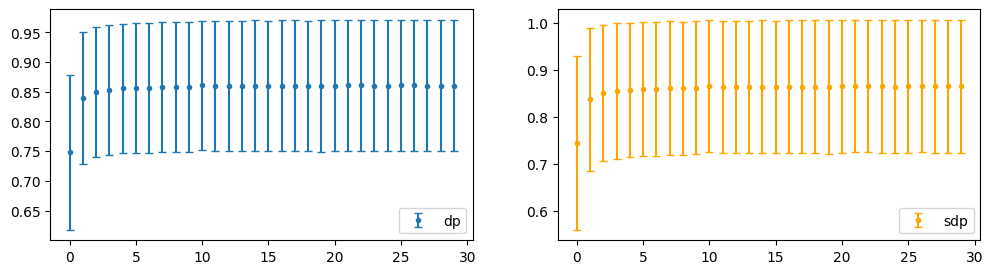

In [ ]:
validation_metrics.plot_progres_bar(statistics_validation)

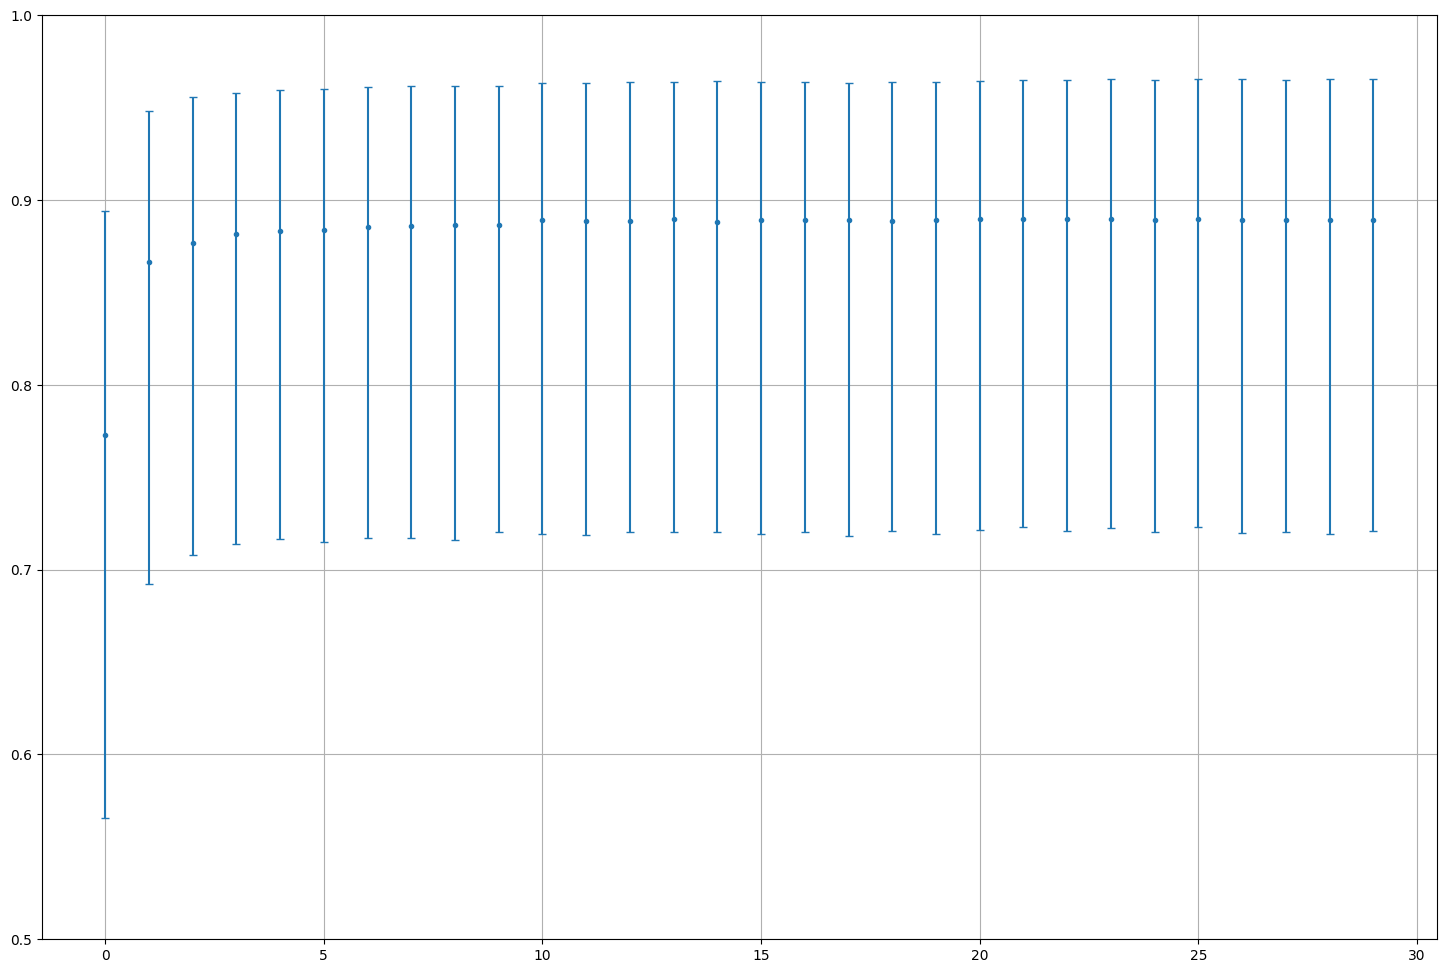

In [ ]:
validation_metrics.plot_median(statistics_validation)

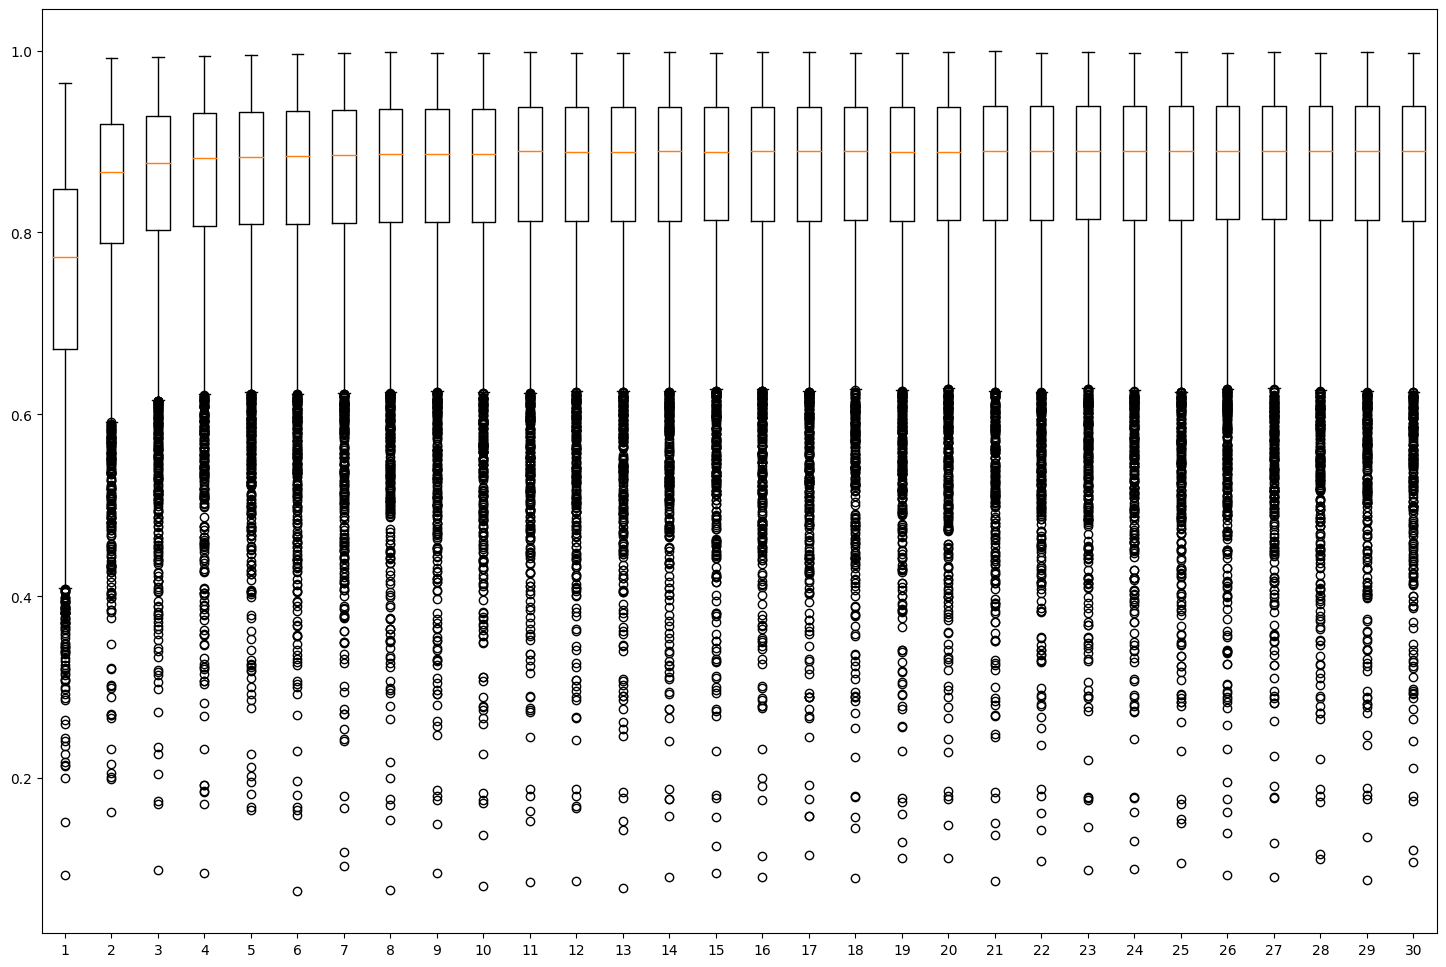

In [ ]:
validation_metrics.plot_boxplot_outliers(statistics_validation)

# FINAL TEST

In [ ]:
with open("/content/drive/MyDrive/NIST_SMALL/Preprocessed_test_pow_preparation_no_sparse_small.output", 'rb') as handle:
    data_list_test  = pickle.load(handle)

In [ ]:
heads = 4
dropout = 0.1
model = TRANSFORMER_CONV_MESSAGE_BIG(heads, dropout)
checkpoint = torch.load("/content/drive/MyDrive/NIST_SMALL/TRANSFORMER_CONV_MESSAGE_BIG_POW/290.pt", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

TRANSFORMER_CONV_MESSAGE_BIG(
  (initial_conv): TransformerConv(50, 200, heads=4)
  (conv1): TransformerConv(800, 200, heads=4)
  (conv2): TransformerConv(800, 200, heads=4)
  (conv3): TransformerConv(800, 200, heads=4)
  (conv4): TransformerConv(800, 200, heads=4)
  (bottleneck): Linear(in_features=200, out_features=2000, bias=True)
  (skip1): SKIPblock(
    (hidden1): Linear(in_features=2000, out_features=2000, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (relu1): ReLU()
    (hidden2): Linear(in_features=2000, out_features=2000, bias=True)
    (dropout2): Dropout(p=0.2, inplace=False)
    (relu2): ReLU()
  )
  (skip2): SKIPblock(
    (hidden1): Linear(in_features=2000, out_features=2000, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (relu1): ReLU()
    (hidden2): Linear(in_features=2000, out_features=2000, bias=True)
    (dropout2): Dropout(p=0.2, inplace=False)
    (relu2): ReLU()
  )
  (skip3): SKIPblock(
    (hidden1): Linear(in_features=2000, out_fe

In [ ]:
matchms.set_matchms_logger_level("ERROR")

test_loader_unshuffled = DataLoader(data_list_test, 
                         batch_size=BATCH, shuffle=False)

true_list, pred_list, dp, sdp = validation_metrics.validate_dataset(test_loader_unshuffled, model)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


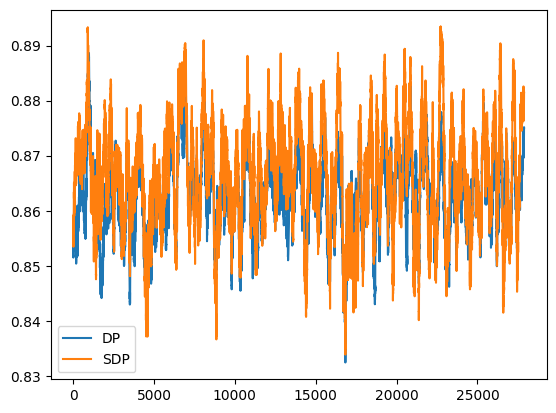

In [ ]:
win = 200
smooth_dp = np.convolve(dp, np.ones(win)/win, mode='valid')
smooth_sdp = np.convolve(sdp, np.ones(win)/win, mode='valid')

plt.plot(smooth_dp,label='DP')
plt.plot(smooth_sdp,label='SDP')
plt.legend()

plt.show()

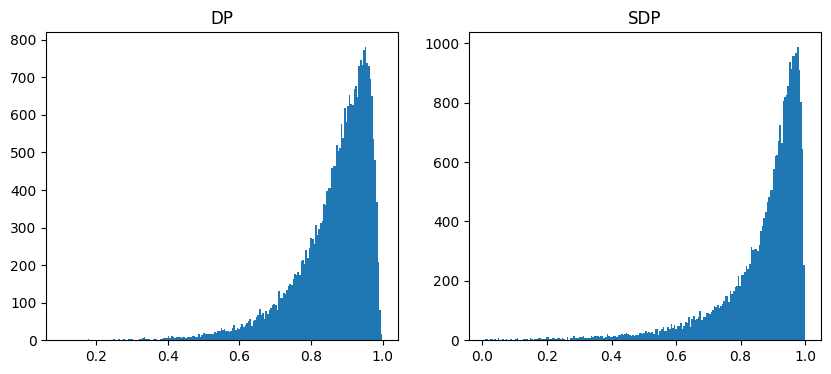

In [ ]:
bins = 200
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(dp,label='dp',bins=bins)
plt.title('DP')
plt.subplot(122)
plt.hist(sdp,label='sdp',bins=bins)
plt.title('SDP')
plt.show()

In [ ]:
print(f" | DotProduct mean is: {np.mean(dp)} and standard deviation is {np.std(dp)}")

print(f" | SteinDotProduct mean is: {np.mean(sdp)} and standard deviation is {np.std(sdp)}")

 | DotProduct mean is: 0.8602759136568555 and standard deviation is 0.11033968262067002
 | SteinDotProduct mean is: 0.8649515435880326 and standard deviation is 0.1409463439341443


In [ ]:
test_loader_unshuffled = DataLoader(data_list_test, 
                         batch_size=1, shuffle=False)
validation_metrics.measure_time(test_loader_unshuffled, model)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


28082
[0.36200761795043945, 0.2766458988189697, 0.21637535095214844, 0.21405673027038574, 0.21323108673095703, 0.23871064186096191, 0.23140692710876465, 0.24713134765625, 0.2321915626525879, 0.2083268165588379, 0.18966126441955566, 0.20211243629455566, 0.19242477416992188, 0.19498085975646973, 0.1951274871826172, 0.20882248878479004, 0.19808602333068848, 0.20365166664123535, 0.19879388809204102, 0.19063758850097656, 0.2119755744934082, 0.1907665729522705, 0.2016911506652832, 0.19411587715148926, 0.19365382194519043, 0.19168663024902344, 0.18888020515441895, 0.19381117820739746, 0.1991291046142578, 0.18876099586486816, 0.1920773983001709, 0.20257806777954102, 0.19817066192626953, 0.19167256355285645, 0.194624662399292, 0.20286321640014648, 0.1930065155029297, 0.19560742378234863, 0.19468355178833008, 0.1952192783355713, 0.19821500778198242, 0.19428491592407227, 0.19909048080444336, 0.19475436210632324, 0.2005777359008789, 0.19731354713439941, 0.19344377517700195, 0.21393418312072754, 0.